# Skin Color Estimation

In [1]:
from pathlib import Path
from pprint import pprint

import cv2 as cv
import numpy as np

import matplotlib
from matplotlib import pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

from saac.utils import cv_imshow, color_show, quadrant_bboxes, crop_bbox
from saac.models import SkinColorMeanExtractor, SkinColorModeExtractor
from saac.process import ImageEqualizer, MidJourneyProcessor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Sample Midjourney image

..\..\data\images\raw\alocasia_a_community_health_worker_photorealistic_325f6686-ee76-4dba-b104-2db91382f57f.png


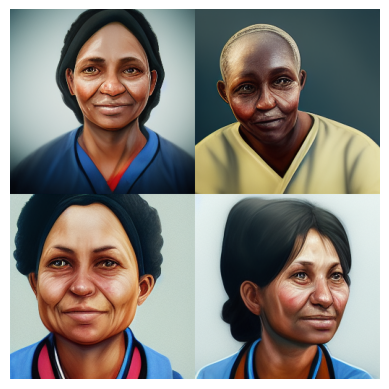

In [4]:
images_root = Path('../../data/images/raw')

img_path = list(images_root.glob('*.png'))[23]
print(img_path)

img_2x2 = cv.imread(str(img_path))
cv_imshow(img_2x2)

### Crop quadrant and get DeepFace predictions

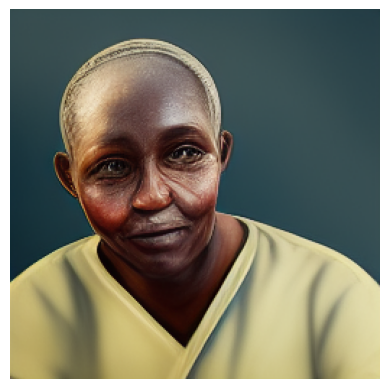

In [5]:
image = crop_bbox(img_2x2, quadrant_bboxes(img_2x2.shape[:2])[2])
cv_imshow(image)

1/1 [==============================] - 0s 311ms/step
{'bbox': [47, 53, 152, 191],
 'gender': {'Man': 86.08391284942627, 'Woman': 13.916082680225372},
 'skin color': (149.79609086106709, 112.86846275752774, 94.09614368726889)}


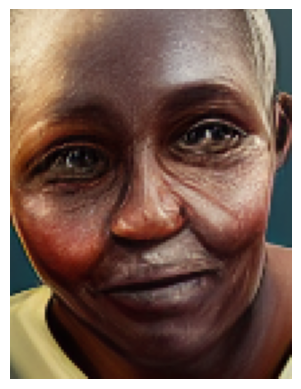

In [6]:
processor = MidJourneyProcessor()

preds = processor.image_predictions(image)
pprint(preds)
bbox = preds['bbox']
face = crop_bbox(image, bbox)
cv_imshow(face)

## Apply skin color extractors

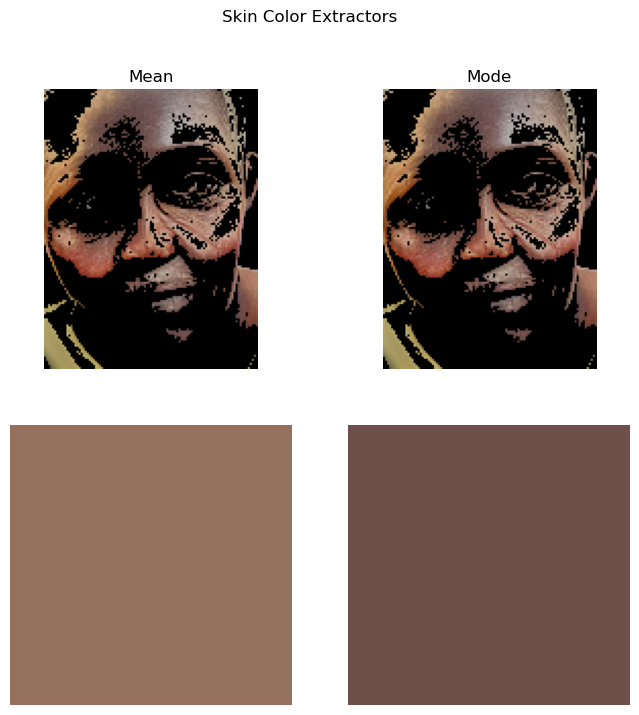

In [25]:
lower_quantile = 0.5
upper_quantile = 0.9
rgb_threshold = True
hist_bins = 25

mean_extractor = SkinColorMeanExtractor(
    lower_quantile=lower_quantile,
    upper_quantile=upper_quantile,
)

mode_extractor = SkinColorModeExtractor(
    lower_quantile=lower_quantile,
    upper_quantile=upper_quantile,
    hist_bins=hist_bins
)

mean_color, mean_mask = mean_extractor.extract(face)
mode_color, mode_mask = mode_extractor.extract(face)

fig, ax = plt.subplots(2, 2, figsize=(8, 8))

cv_imshow(face*mean_mask[:, :, np.newaxis], ax=ax[0,0])
color_show(mean_color, ax=ax[1, 0])
ax[0,0].set_title('Mean')

cv_imshow(face*mode_mask[:, :, np.newaxis], ax=ax[0,1])
color_show(mode_color, ax=ax[1, 1])
ax[0,1].set_title('Mode')

fig.suptitle('Skin Color Extractors');

## Apply image equalizer before extraction

Text(0.5, 1.0, 'Equalized')

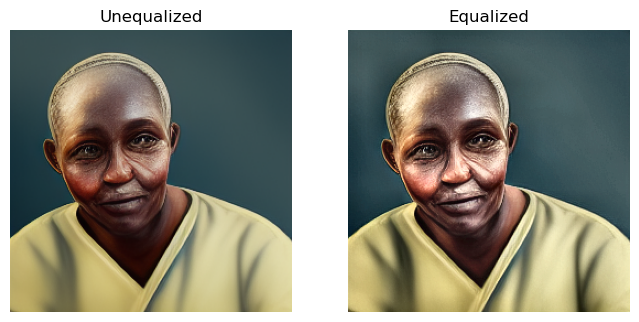

In [35]:
clip_limit = 2.0
grid_size = 8

equalizer = ImageEqualizer(
    clipLimit=clip_limit,
    grid_size=grid_size
)

image_cl = equalizer.equalize(image)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
                       
cv_imshow(image, ax=ax[0])
ax[0].set_title('Unequalized')

cv_imshow(image_cl, ax=ax[1])
ax[1].set_title('Equalized')

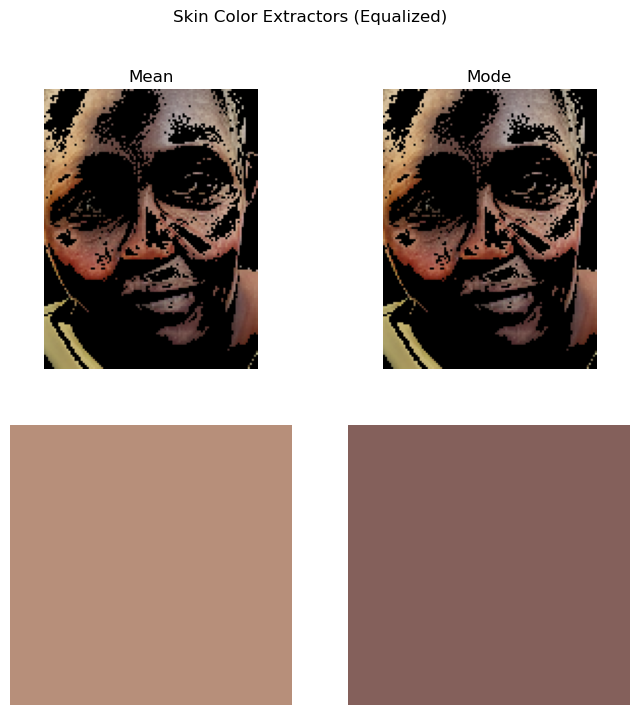

In [36]:
face_cl = crop_bbox(image_cl, bbox)

mean_color, mean_mask = mean_extractor.extract(face_cl)
mode_color, mode_mask = mode_extractor.extract(face_cl)

fig, ax = plt.subplots(2, 2, figsize=(8, 8))

cv_imshow(face*mean_mask[:, :, np.newaxis], ax=ax[0,0])
color_show(mean_color, ax=ax[1, 0])
ax[0,0].set_title('Mean')

cv_imshow(face*mode_mask[:, :, np.newaxis], ax=ax[0,1])
color_show(mode_color, ax=ax[1, 1])
ax[0,1].set_title('Mode')

fig.suptitle('Skin Color Extractors (Equalized)');